In [179]:
%load_ext autoreload
%autoreload 2

import numpy as np
import json


experiments = ["first"]
seeds = [10]
plot_std = True
p = json.load(
    open(f"figures/{experiments[0]}/parameters.json")
)
algorithm = "DQN"
selected_epochs = np.arange(p["n_epochs"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extract data

In [180]:
dqn_scores = {}
for experiment in experiments:
    dqn_scores[experiment] = {}
    dqn_scores[experiment] = np.zeros((p["n_epochs"], len(seeds))) * np.nan
    for idx_seed, seed in enumerate(seeds):
        dqn_scores[experiment][:, idx_seed] = np.load(f"figures/{experiment}/{algorithm}/J_{seed}.npy")

### IQM vs iterations & performance profile

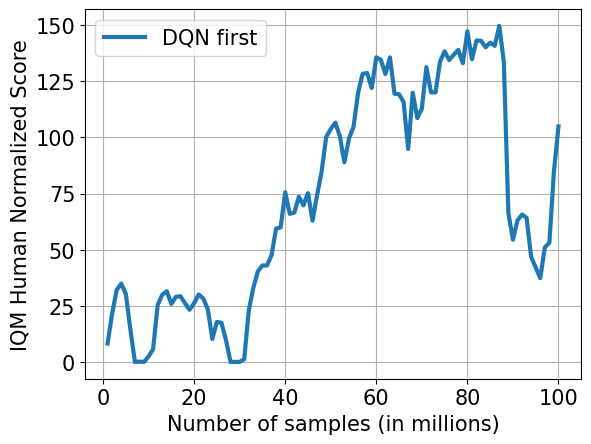

In [181]:
import matplotlib.pyplot as plt
from dqn.utils.process_scores import compute_iqm_and_confidence_interval


plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

for experiment in experiments:
    iqms, iqms_confidence_interval = compute_iqm_and_confidence_interval(dqn_scores[experiment], selected_epochs)
    plt.plot(selected_epochs + 1, iqms, label=f"{algorithm} {experiment}")
    if plot_std:
        plt.fill_between(selected_epochs + 1, iqms_confidence_interval[0, :], iqms_confidence_interval[1, :], alpha=0.3)

plt.grid(zorder=0)
plt.xlabel("Number of samples (in millions)")
plt.ylabel("IQM Human Normalized Score")
_ = plt.legend()

/home/theo/ai_olympics_project/double_pendulum/src/python
/home/theo/ai_olympics_project/double_pendulum/src/python/experiments/pendubot


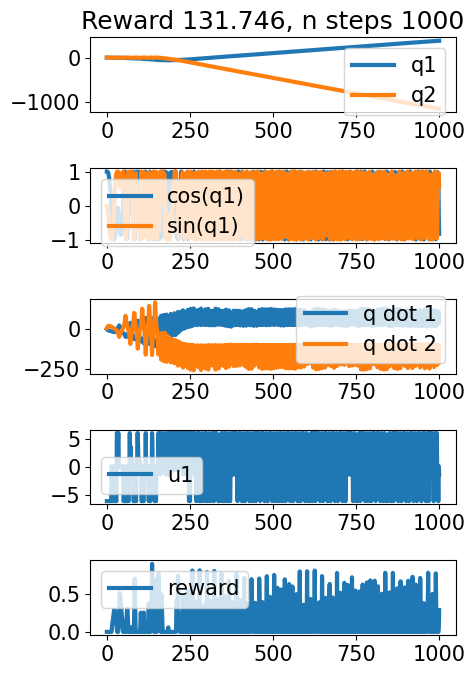

In [182]:
if algorithm == "DQN":
    %cd ../..
    import jax
    from dqn.environments.double_pendulum import PendubotEnv
    from dqn.environments import mpar, dt, integrator, x0, goal
    from dqn.networks.q_architectures import DoublePendulumDQN
    from dqn.utils.pickle import load_pickled_data

    best_params = np.argmax(iqms)

    env = PendubotEnv(mpar, dt, p["n_repeated_actions"], integrator, x0, goal, p["n_actions"])
    env.reset()
    q = DoublePendulumDQN(
        (6,),
        env.n_actions,
        p["gamma"],
        p["layers_dimensions"],
        jax.random.PRNGKey(0),
        p["dqn_learning_rate"],
        p["n_training_steps_per_online_update"],
        p["dqn_n_training_steps_per_target_update"],
    )
    %cd experiments/pendubot
    q.params = load_pickled_data(f"figures/{experiments[0]}/DQN/Q_10_{best_params}_best_online_params")
    absorbing = False
    rewards = []
    q_1 = []
    q_2 = []
    q_prime_1 = []
    q_prime_2 = []
    actions = []

    while not absorbing and env.n_steps < p["horizon"]:
        action = q.best_action(None, q.params, env.state)
        _, reward, absorbing, _ = env.step(action)

        rewards.append(reward)
        q_1.append(env.simulator.x[0])
        q_2.append(env.simulator.x[1])
        q_prime_1.append(env.simulator.x[2])
        q_prime_2.append(env.simulator.x[3])
        actions.append(env.actions[action])

    fig, axes = plt.subplots((5), figsize=(5, 7))

    axes[0].plot(q_1, label="q1")
    axes[0].plot(q_2, label="q2")
    axes[0].legend()
    axes[0].set_title(f"Reward {np.around(sum(rewards), 3)}, n steps {env.n_steps}")
    axes[1].plot(np.cos(q_1), label="cos(q1)")
    axes[1].plot(np.sin(q_1), label="sin(q1)")
    axes[1].legend()
    axes[2].plot(q_prime_1, label="q dot 1")
    axes[2].plot(q_prime_2, label="q dot 2")
    axes[2].legend()
    axes[3].plot(actions, label="u1")
    axes[3].legend()
    axes[4].plot(rewards, label="reward")
    axes[4].legend()
    fig.tight_layout()